In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline






 ## Load and Explore Data

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639

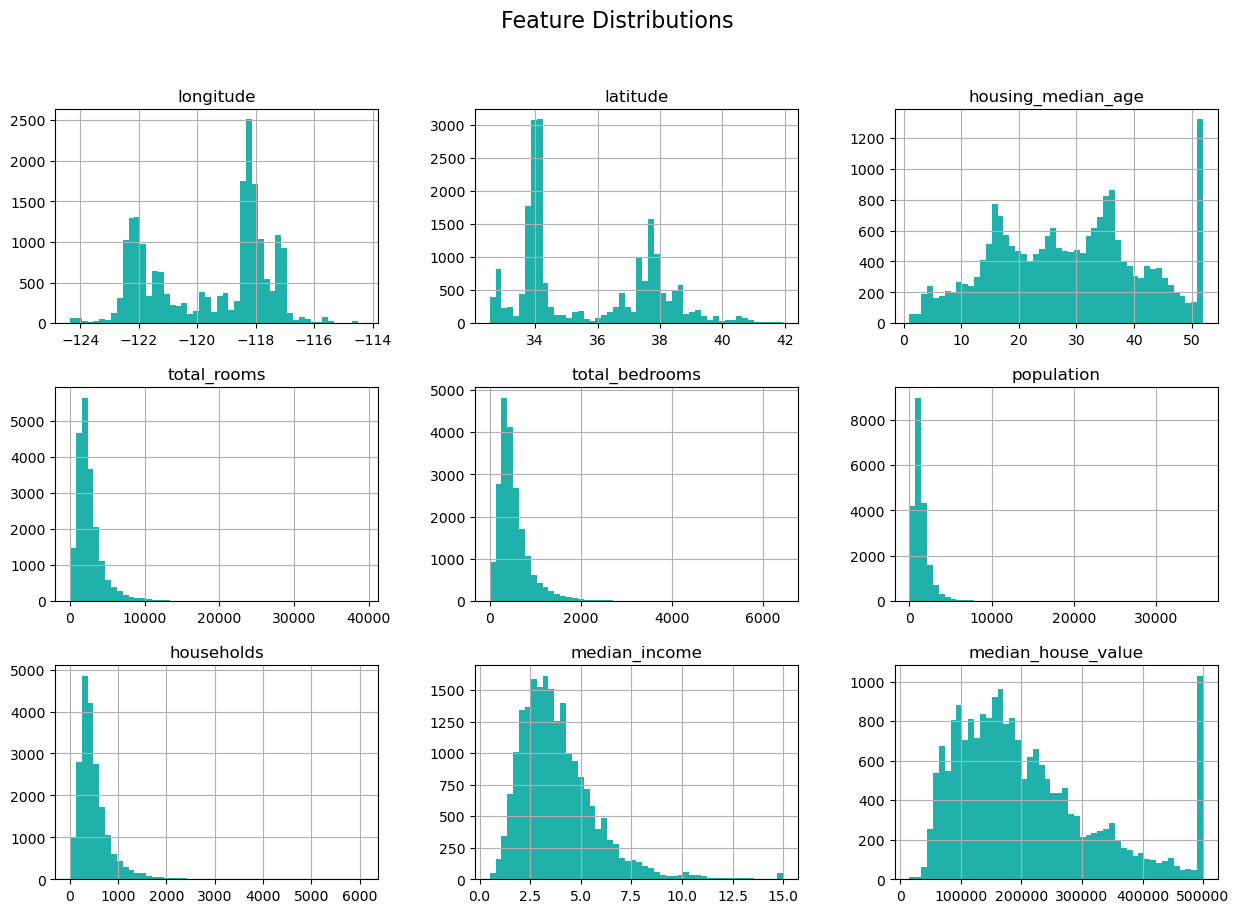

In [2]:
# Load the dataset
housing = pd.read_csv("housing.csv")

# Preview the data
print(housing.head())
print(housing.info())
print(housing.describe())

# Visualize distributions
housing.hist(bins=50, figsize=(15, 10), color="lightseagreen")
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

C:\Users\maria pires pacheco\AppData\Local\Temp\ipykernel_22904\307649193.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=housing,x="total_rooms", palette="Greens")


<Axes: xlabel='total_rooms'>

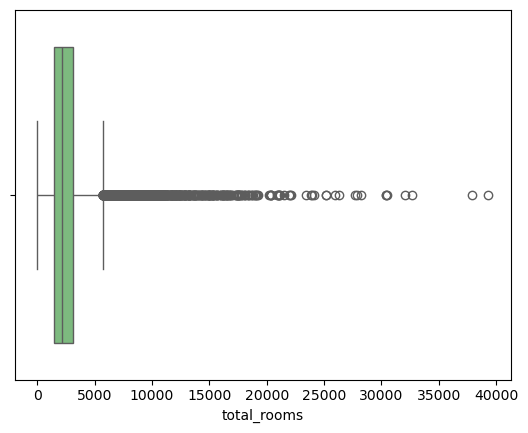

In [3]:
sns.boxplot(data=housing,x="total_rooms", palette="Greens")


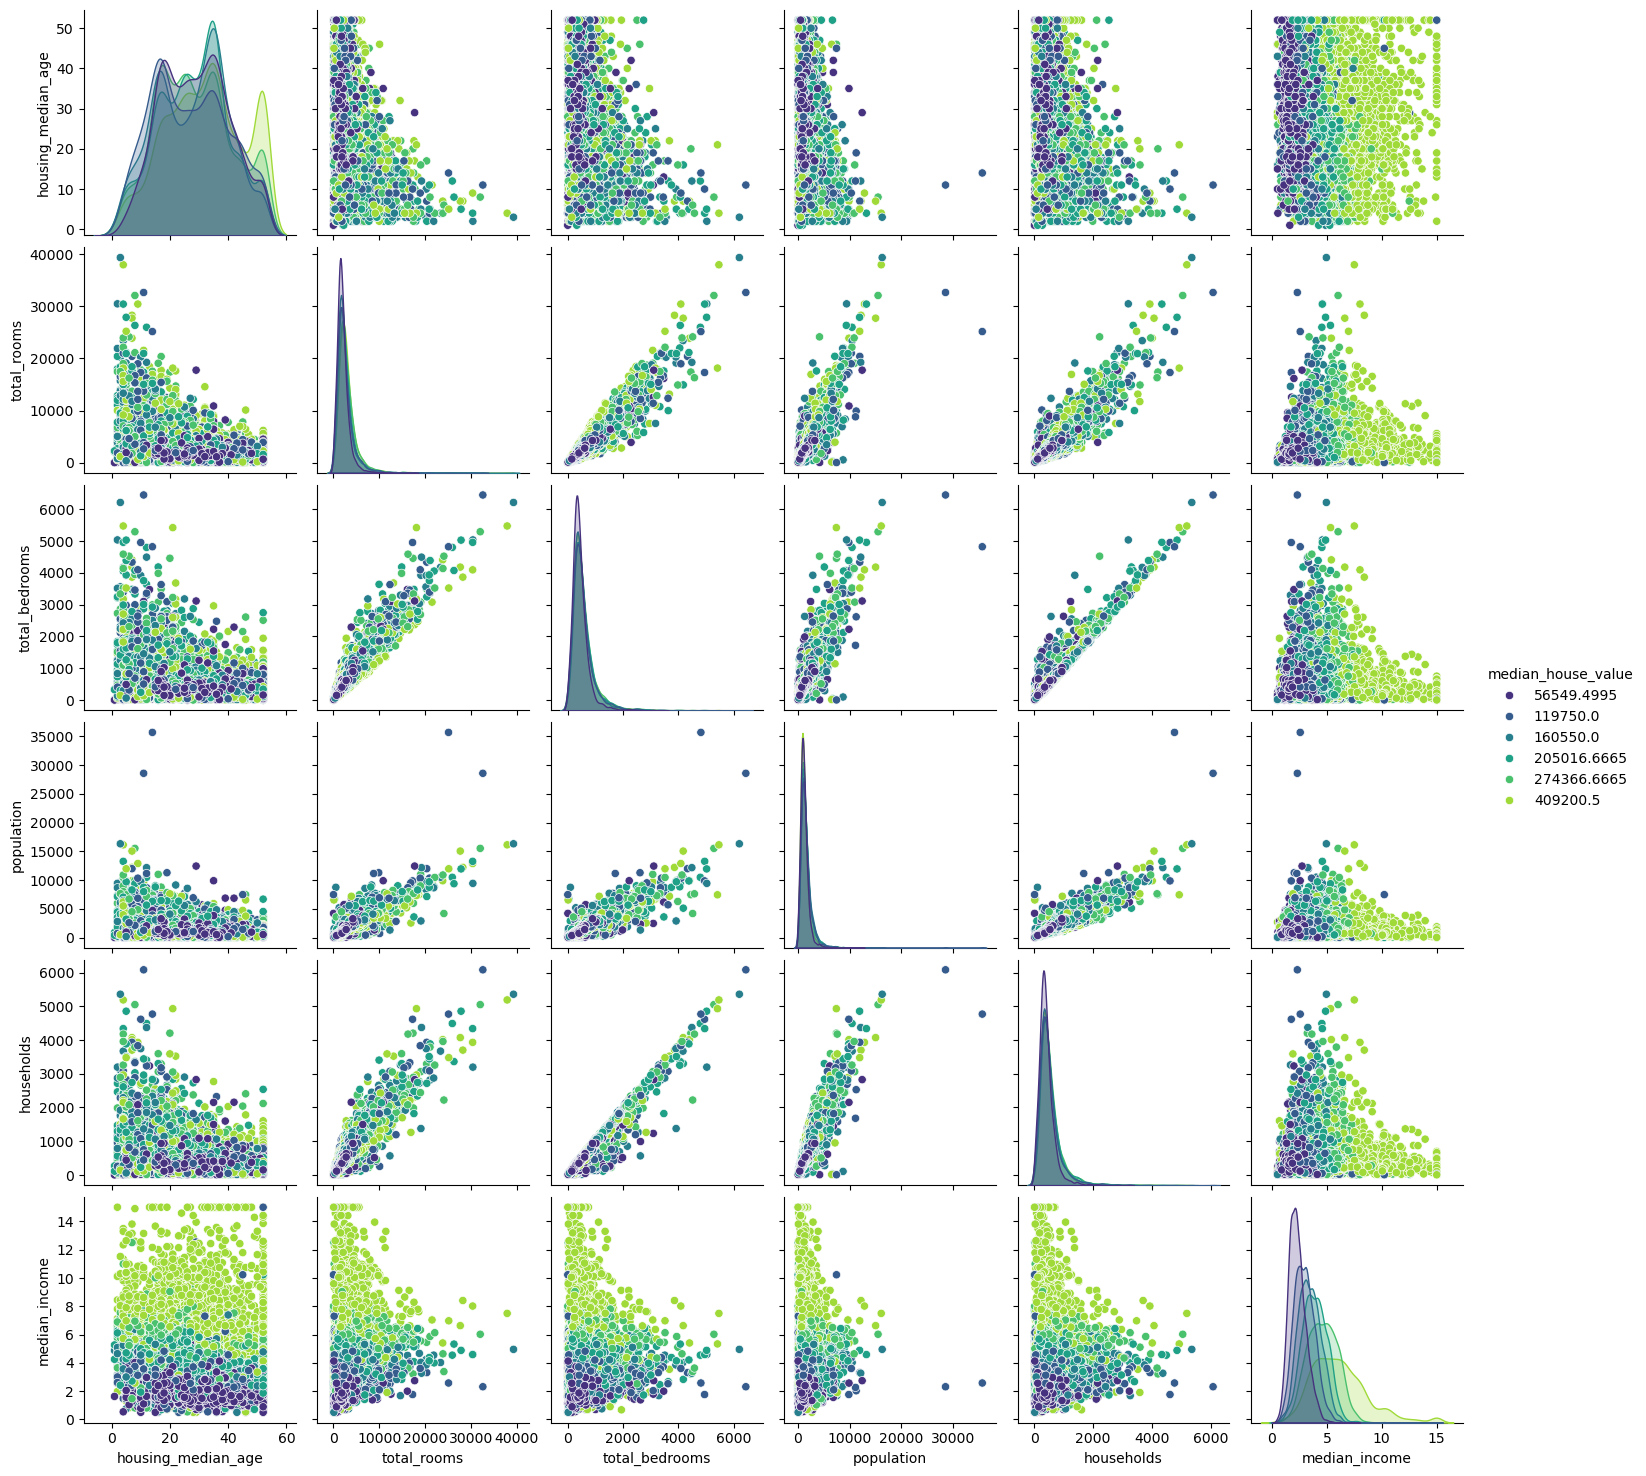

In [4]:
columns_drop = ["longitude", "latitude"]

# Drop columns from the original DataFrame 'housing'
subset = housing.drop(columns=columns_drop)

# Quantize the target into 6 equal-frequency bins
subset["median_house_value"] = pd.qcut(subset["median_house_value"], 6)

# Convert categorical intervals to midpoints
subset["median_house_value"] = subset["median_house_value"].apply(lambda interval: (interval.left + interval.right) / 2)

_ = sns.pairplot(data=subset, hue="median_house_value", palette="viridis")



## Finding Correlations


In [5]:
numeric_df = housing.select_dtypes(include=[np.number])


numeric_df.corr().sort_values(ascending=False, by = 'median_house_value').median_house_value

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

## Vizualize correlation levels

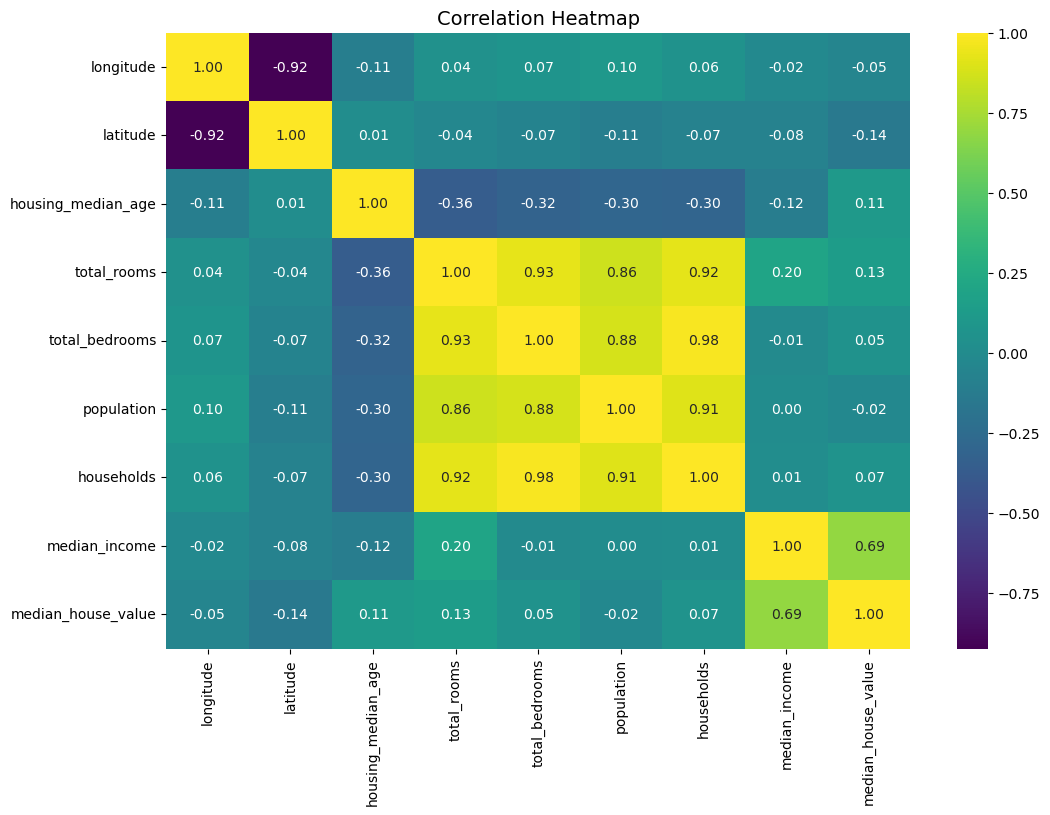

In [6]:
numeric_df = housing.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="viridis", fmt=".2f")
plt.title("Correlation Heatmap", fontsize=14)
plt.show()


## Visualize the locations of the houses

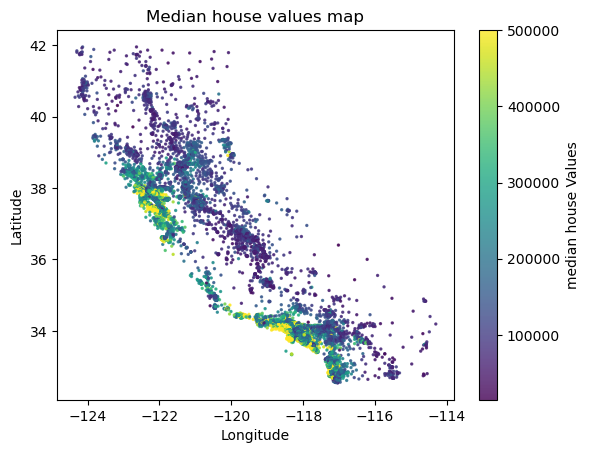

In [7]:
plt.scatter(data= housing, x='longitude',y='latitude', c='median_house_value', cmap='viridis', s=2, alpha=0.8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Median house values map')
plt.colorbar(label='median house Values')
plt.show()


## PCA 

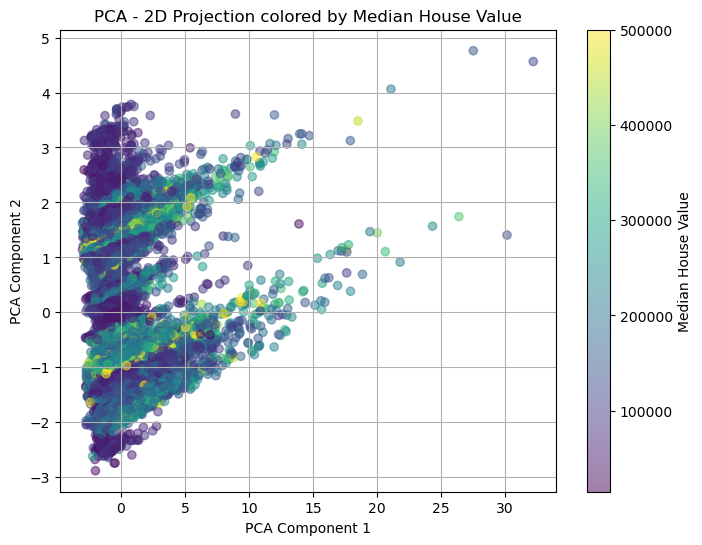

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # fills NaNs with median of each column
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2))
])
housing2= housing.drop("median_house_value", axis=1)
x = housing2.select_dtypes(include=[np.number])
y = housing["median_house_value"]

x_pca = pipeline.fit_transform(x)


plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y, cmap="viridis", alpha=0.5)
plt.colorbar(scatter, label="Median House Value")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA - 2D Projection colored by Median House Value")
plt.grid(True)
plt.show()



## Split the data set into training and test set

In [9]:

X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
X_train.head()
y_test.head()

20046     47700.0
3024      45800.0
15663    500001.0
20484    218600.0
9814     278000.0
Name: median_house_value, dtype: float64

## Remove capped values

In [11]:
from sklearn.base import BaseEstimator, RegressorMixin, clone

class CappedRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_estimator, quantile=0.99):
        self.base_estimator = base_estimator
        self.quantile = quantile

    def fit(self, X, y):
        # Calculer le cap sur y
        self.cap_ = np.quantile(y, self.quantile)
        # Clipper y puis entraîner le modèle interne
        y_capped = np.clip(y, None, self.cap_)
        self.estimator_ = clone(self.base_estimator).fit(X, y_capped)
        return self

    def predict(self, X):
        # Prédiction brute
        y_pred = self.estimator_.predict(X)
        # On remet sous le cap pour rester cohérent
        return np.clip(y_pred, None, self.cap_)
    @property
    def feature_importances_(self):
        if hasattr(self.estimator_, "feature_importances_"):
            return self.estimator_.feature_importances_
        else:
            raise AttributeError(f"{type(self.estimator_).__name__} n'a pas d'attribut feature_importances_.")




## Remove outliers

In [12]:


class OutlierRemoverX(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor
        self.mask_ = None

    def fit(self, X, y=None):
        num = X.select_dtypes(include=[float, int])
        Q1 = num.quantile(0.25)
        Q3 = num.quantile(0.75)
        IQR = Q3 - Q1
        self.lower_ = Q1 - self.factor * IQR
        self.upper_ = Q3 + self.factor * IQR
        return self

    def transform(self, X):
        num = X.select_dtypes(include=[float, int])
        self.mask_ = ~((num < self.lower_) | (num > self.upper_)).any(axis=1)
        return X.loc[self.mask_].copy()

    def get_mask(self):
        return self.mask_


## Feature engeneering

In [13]:

class FeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self,
                 lat1=34.0522, lon1=-118.2437,
                 lat2=37.7925, lon2=-122.4382):
        self.lat1, self.lon1 = lat1, lon1
        self.lat2, self.lon2 = lat2, lon2

    def haversine(self, lat1, lon1, lat2, lon2):
        R = 6371.0
        lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
        dlon, dlat = lon2 - lon1, lat2 - lat1
        a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        return R * c

    def fit(self, X, y=None):
        return self  # rien à calculer

    def transform(self, X):
        X = X.copy()
        # ratios
        X['rooms_per_household']      = X['total_rooms'] / X['households']
        X['bedrooms_per_room']        = X['total_bedrooms'] / X['total_rooms']
        X['population_per_household'] = X['population'] / X['households']
        # distances vectorisées
        lat_rad   = np.radians(X['latitude'])
        lon_rad   = np.radians(X['longitude'])
        lat0_LA   = math.radians(self.lat1)
        lon0_LA   = math.radians(self.lon1)
        lat0_SF   = math.radians(self.lat2)
        lon0_SF   = math.radians(self.lon2)

        # Distance to LA
        dlat_LA = lat_rad - lat0_LA
        dlon_LA = lon_rad - lon0_LA
        a_LA = np.sin(dlat_LA/2)**2 + np.cos(lat0_LA)*np.cos(lat_rad)*np.sin(dlon_LA/2)**2
        X['Distance_LA'] = 2 * 6371 * np.arctan2(np.sqrt(a_LA), np.sqrt(1 - a_LA))

        # Distance to SF
        dlat_SF = lat_rad - lat0_SF
        dlon_SF = lon_rad - lon0_SF
        a_SF = np.sin(dlat_SF/2)**2 + np.cos(lat0_SF)*np.cos(lat_rad)*np.sin(dlon_SF/2)**2
        X['Distance_SF'] = 2 * 6371 * np.arctan2(np.sqrt(a_SF), np.sqrt(1 - a_SF))

        return X


## Remove Correlated features

In [14]:

class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95, target_col="median_house_value"):
        self.threshold = threshold
        self.target_col = target_col

    def fit(self, X, y):
        df = X.copy()
        df[self.target_col] = y
        corr = df.corr().abs()
        self.target_corr_ = corr[self.target_col]
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

        to_drop = set()
        for col in upper.columns:
            high_corr = upper[col][upper[col] > self.threshold].index
            for corr_col in high_corr:
                if self.target_corr_[col] < self.target_corr_[corr_col]:
                    to_drop.add(col)
                else:
                    to_drop.add(corr_col)
        self.to_drop_ = list(to_drop)
        return self

    def transform(self, X):
        return X.drop(columns=self.to_drop_, errors="ignore")


## Data Imputation

In [15]:
class DataFrameImputer(BaseEstimator, TransformerMixin):
    def __init__(self, num_strategy='median', cat_strategy='most_frequent'):
        self.num_strategy = num_strategy
        self.cat_strategy = cat_strategy

    def fit(self, X, y=None):
        num_cols = X.select_dtypes(include=[float, int]).columns
        cat_cols = X.select_dtypes(include=['object', 'category']).columns

        # Imputation numérique
        if self.num_strategy in ('mean', 'median'):
            self.num_impute_values_ = getattr(X[num_cols], self.num_strategy)()
        else:
            self.num_impute_values_ = pd.Series(0, index=num_cols)

        # Imputation catégorielle
        self.cat_impute_values_ = pd.Series(dtype='object')
        if len(cat_cols) > 0:
            mode_df = X[cat_cols].mode()
            if not mode_df.empty:
                # mode_df.iloc[0] existe
                self.cat_impute_values_ = mode_df.iloc[0]
            else:
                # si mode_df vide, on met 'missing'
                self.cat_impute_values_ = pd.Series('missing', index=cat_cols)
        return self

    def transform(self, X):
        X = X.copy()
        # Imputer num
        for col, val in self.num_impute_values_.items():
            X[col] = X[col].fillna(val)
        # Imputer cat
        for col, val in self.cat_impute_values_.items():
            X[col] = X[col].fillna(val)
        return X


In [16]:
num_cols = X.select_dtypes(include=['float64', 'int64']).columns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector

# Numeric and categorical selectors
num_selector = make_column_selector(dtype_include=["int64", "float64"])
cat_selector = make_column_selector(dtype_include=["object"])

# Pipelines
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Full preprocessing pipeline
preprocessing = ColumnTransformer([
    ("num", numeric_pipeline, num_selector),
    ("cat", categorical_pipeline, cat_selector)
])


In [17]:
# 1. Suppression des outliers (hors pipeline)
out_rm = OutlierRemoverX(factor=1.5)
X_filtered = out_rm.fit_transform(X_train)
y_filtered = y_train.loc[out_rm.get_mask()]

# Réindexation pour éviter mismatch
X_filtered = X_filtered.reset_index(drop=True)
y_filtered = y_filtered.reset_index(drop=True)

# 2. Pipeline sans suppression
pipeline = Pipeline([
    ("feature_adder", FeatureAdder()),
    ("imputer", DataFrameImputer(
        num_strategy='median',
        cat_strategy='most_frequent'
    )),
    ("preprocessing", preprocessing),
    ("model", CappedRegressor(
        base_estimator=XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='reg:squarederror',
            random_state=42
        ),
        quantile=0.99
    ))
])

# 3. Entraînement sur données filtrées
pipeline.fit(X_filtered, y_filtered)

# 4. Prédiction sur test complet (sans suppression)
y_pred = pipeline.predict(X_test)

print("Test RMSE :", root_mean_squared_error(y_test, y_pred))
print("Test R²   :", r2_score(y_test, y_pred))


Test RMSE : 45984.05131140934
Test R²   : 0.8386356465712798


In [18]:
from sklearn.model_selection import KFold, cross_val_score

# Step 1: Remove outliers from X and y BEFORE pipeline and CV
def remove_outliers(X, y, factor=1.5):
    # Example: using IQR method on numeric features
    import numpy as np
    import pandas as pd

    X_num = X.select_dtypes(include=np.number)
    Q1 = X_num.quantile(0.25)
    Q3 = X_num.quantile(0.75)
    IQR = Q3 - Q1

    # Detect outliers for each numeric feature
    mask = ~((X_num < (Q1 - factor * IQR)) | (X_num > (Q3 + factor * IQR))).any(axis=1)

    X_filtered = X.loc[mask]
    y_filtered = y.loc[mask] if hasattr(y, "loc") else y[mask]
    return X_filtered, y_filtered

# Apply outlier removal
X_filtered, y_filtered = remove_outliers(X, y, factor=1.5)

# Step 2: Define the pipeline WITHOUT the outlier remover step
pipeline_cv = Pipeline([
    ("features", FeatureAdder()),
    ("imputer", DataFrameImputer()),
    ("preproc", ColumnTransformer([
        ("num", StandardScaler(), make_column_selector(dtype_include=np.number)),
        ("cat", OneHotEncoder(handle_unknown="ignore"), make_column_selector(dtype_include=object))
    ])),
    ("model", XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42
    ))
])

# Step 3: Cross-validation with filtered data
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline_cv, X_filtered, y_filtered, cv=cv, scoring="r2", n_jobs=-1)

print("CV R² scores :", scores)
print("Mean CV R²   :", scores.mean())


CV R² scores : [0.80799146 0.82286679 0.80832291 0.83330996 0.81649355]
Mean CV R²   : 0.8177969316130396


In [19]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define hyperparameter space
param_dist = {
    "model__n_estimators": randint(100, 300),
    "model__learning_rate": uniform(0.05, 0.15),  # tighter around 0.1
    "model__max_depth": randint(4, 8),
    "model__subsample": uniform(0.7, 0.3),
    "model__colsample_bytree": uniform(0.7, 0.3),
    "model__reg_alpha": uniform(0, 0.5),
    "model__reg_lambda": uniform(0.5, 1),
    "model__min_child_weight": randint(1, 6)
}


# Wrap pipeline in RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=pipeline_cv,
    param_distributions=param_dist,
    n_iter=100,  # You can increase this for better results
    cv=5,
    scoring="r2",
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit on your filtered data
search.fit(X_filtered, y_filtered)

# Print results
print("Best parameters:", search.best_params_)
print("Best CV R²     :", search.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'model__colsample_bytree': 0.9305662042918926, 'model__learning_rate': 0.05654056576316507, 'model__max_depth': 7, 'model__min_child_weight': 4, 'model__n_estimators': 257, 'model__reg_alpha': 0.4769642885012937, 'model__reg_lambda': 1.4148643902204485, 'model__subsample': 0.8110476100766333}
Best CV R²     : 0.6158773030060495


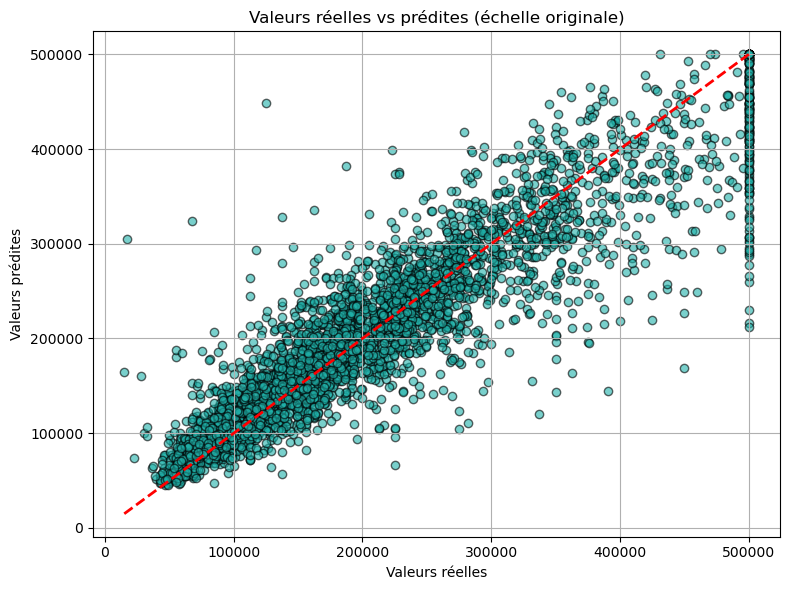

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='lightseagreen', edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # ligne diagonale parfaite
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.title("Valeurs réelles vs prédites (échelle originale)")
plt.grid(True)
plt.tight_layout()
plt.show()
